###### You are very welcome to use this code. For this, clearly acknowledge
###### the source of this code, and cite our papers described in the readme file.

###### Copyright (c) Vadim Holodovsky. The python code is available for
###### non-commercial use and exploration.  For commercial use contact the
###### authors. The authors are not liable for any damages or loss that might be
###### caused by use or connection to this code.
###### All rights reserved.

###### This source code is licensed under the GPL-3.0 license found in the
###### LICENSE file in the root directory of this source tree.
---
# ProbCT uncertainty propagation to downstream task: Solar energy forecast
---
#### This notebook demonstrates the necessity of ProbCT uncertainty estimation on downstream forecast tasks using synthetic data

In [1]:
import at3d
import numpy as np
import xarray as xr
import functools
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import sys

from renderer.at3d_util import hemispheric_projection
from shdom.CloudCT_Utils import *

###### medium parameters and RTE solver parameters by the user

In [2]:
dx = 0.05 #km
dy = 0.05 #km
dz = 0.04 #km

# prepare configs:
# Numerical Parameters:
config = at3d.configuration.get_config('../AT3D/default_config.json')
config['max_total_mb'] = 1000.0
config['adapt_grid_factor'] = 2
config['deltam'] = True
lambertian_surface = at3d.surface.lambertian(0.05)
SZA = 155 # Sun Zenith Angle
solarmu = np.cos(np.deg2rad(SZA)) # Note that `solarmu`=0.0 (purely horizontal solar beam) is not permitted.
solar_azimuth = 0.0
sources = OrderedDict()
mono_paths = OrderedDict()

# bands = [[400,500],[500,600],[600,700],[700,800],[800,900],[900,1100]]
bands = [[450,470],[550,570],[650,670],[850,870],[1050,1070]]

for band in bands:
    wavelength_band = (float_round(1e-3*band[0]),float_round(1e-3*band[1]))
    wavelen1, wavelen2 = wavelength_band
    central_wavelenegth = float_round(0.5*(wavelength_band[1] + wavelength_band[0]))
    print(central_wavelenegth)
    wavelength_averaging = False
    if not os.path.exists('../AT3D/mie_tables'): 
        os.makedirs('../AT3D/mie_tables') 
    mono_formatstr = 'TEST_averaged_Water_{}-{}nm.nc'.format(int(1e3*wavelength_band[0]), int(1e3*wavelength_band[1]))
    mono_path = os.path.join('../AT3D/mie_tables', mono_formatstr)
    mono_paths[central_wavelenegth] = mono_path
    # prepare sources::
    source = at3d.source.solar(wavelength=central_wavelenegth, solarmu=solarmu, solar_azimuth=solar_azimuth, solarflux=1.0, skyrad=0.0)
    sources[central_wavelenegth] = source
    

0.46
0.56
0.66
0.86
1.06


###### Prepare mono mie table (loading if already exists is applied)

In [3]:
# get_mono_table will first search a directory to see if the requested table exists otherwise it will calculate it. 
# You can save it to see if it works.
mie_mono_tables = OrderedDict()

for band in bands:
    wavelength_band = (float_round(1e-3*band[0]),float_round(1e-3*band[1]))
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',wavelength_band,
        max_integration_radius=65.0,
        wavelength_averaging = wavelength_averaging, 
        minimum_effective_radius=0.1,
        relative_dir='../AT3D/mie_tables',
        verbose=False
    )
    central_wavelenegth = float_round(0.5*(wavelength_band[1] + wavelength_band[0]))
    print(central_wavelenegth)

    mie_mono_table.to_netcdf(mono_paths[central_wavelenegth])
    mie_mono_tables[central_wavelenegth] = mie_mono_table
    

0.46
0.56
0.66
0.86
1.06


###### Define the size distribution function and get optical property generators

In [4]:
# We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma
optical_prop_gen = at3d.medium.OpticalPropertyGenerator(
        'cloud',
        mie_mono_tables, 
        size_distribution_function,
        particle_density=1.0, 
        maxnphase=None,
        interpolation_mode='exact',
        density_normalization='density',#The density_normalization argument is a convenient
        reff=np.linspace(1,20.0,20),
        veff=np.linspace(0.05,0.15,15)
    )
    
poly_tables = OrderedDict()


for central_wavelenegth in mie_mono_tables.keys():
    
    size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_tables[central_wavelenegth].radius,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0, radius_units='micron',
        reff=np.linspace(1,20.0,20),
        veff=np.linspace(0.05,0.15,15))

    poly_table = at3d.mie.get_poly_table(size_distribution, mie_mono_tables[central_wavelenegth])
    poly_tables[central_wavelenegth] = poly_table
extinctions = OrderedDict()
radius = OrderedDict()
for central_wavelenegth in mie_mono_tables.keys():
    extinctions[central_wavelenegth] = mie_mono_tables[central_wavelenegth]['extinction']
    
    radius[central_wavelenegth] = mie_mono_tables[central_wavelenegth].coords['radius'].values

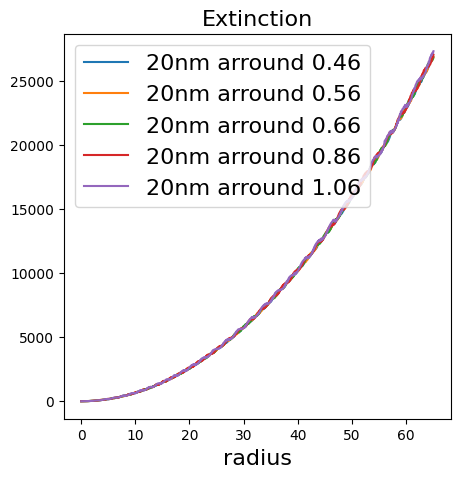

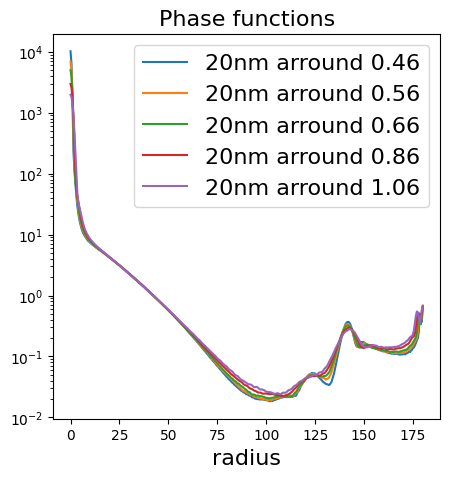

In [5]:
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(5,5))
for central_wavelenegth in mie_mono_tables.keys():

    ax.plot(radius[central_wavelenegth],extinctions[central_wavelenegth] , \
                 label='20nm arround {}'.format(central_wavelenegth))

ax.set_title('Extinction', fontsize=16)
ax.legend(fontsize=16)
ax.set_xlabel('radius', fontsize=16)

f, ax = plt.subplots(1, 1, figsize=(5,5))
for central_wavelenegth in mie_mono_tables.keys():

    phase_function = at3d.util.get_phase_function(poly_tables[central_wavelenegth].legcoef[...,0], np.linspace(0.0,180.0,360), phase_elements='All')
        
    ax.semilogy(phase_function.scattering_angle.values,phase_function[0,...].sel(reff=10) , \
                 label='20nm arround {}'.format(central_wavelenegth))

ax.set_title('Phase functions', fontsize=16)
ax.legend(fontsize=16)
ax.set_xlabel('radius', fontsize=16)
plt.show()

#### Make the RTE grid and medium microphysics.

This time we are going to include both cloud and rayleigh scatter. The fundamental thing that must be defined first is the rte_grid, which sets the domain size.

In [6]:
# air:
#load atmosphere
atmosphere = xr.open_dataset('../AT3D/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 100.0]})
# reduced_atmosphere

In [7]:
# make the optical properties
file_name_stamp = 'beta_est'
# file_name_stamp = 'beta_m_1std'

file_name_stamp_input = file_name_stamp+'.txt'
file_name_stamp_output = "third_run_"+file_name_stamp+'.mat'
ref_folder = 'files'
file_name = os.path.join(ref_folder, file_name_stamp_input)
cloud_scatterer = \
    at3d.util.load_from_csv(file_name,density='lwc',origin=(0.0,0.0))
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])  
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                              cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                              merged_z_coordinate)

#### Make the Optical Properties

In [8]:
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)
cloud_scatterer_on_rte_grid.density.data[cloud_scatterer_on_rte_grid.density.data<0]=0
optical_properties = optical_prop_gen(cloud_scatterer_on_rte_grid)
# generate rayleigh scattering.
# one function to generate rayleigh scattering.
wavelengths = np.array(list(mie_mono_tables.keys()))
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

#### Define Solvers

Define solvers last based on the sensor's spectral information.

In [9]:
solvers_dict = at3d.containers.SolversDict()
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.

for wavelength in wavelengths:
    print(wavelength)
    medium = {
        'cloud': optical_properties[wavelength],
        'rayleigh':rayleigh_scattering[wavelength]
     }
    config = at3d.configuration.get_config()
    solvers_dict.add_solver(
        wavelength,
        at3d.solver.RTE(
            numerical_params=config,
            surface=at3d.surface.lambertian(0.05),
            source=sources[wavelength],
            medium=medium,
            num_stokes=1 #sensor_dict.get_minimum_stokes()[wavelength],
        )                   
   )
solvers_dict.solve()

0.46
0.56
0.66
0.86
1.06
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.460 micron]
     1  -0.939  0.103E+00   109568    11.87  0.046   [Radiance 0.460 micron]
     2  -1.789  0.985E-01   109568    11.87  0.046   [Radiance 0.460 micron]
     3  -2.302  0.858E-01   109572    11.88  0.046   [Radiance 0.460 micron]
     4  -2.654  0.563E-01   109759    12.29  0.048   [Radiance 0.460 micron]
     5  -2.754  0.390E-01   110380    13.61  0.053   [Radiance 0.460 micron]
     6  -3.005  0.312E-01   110982    14.85  0.058   [Radiance 0.460 micron]
     7  -3.312  0.300E-01   111196    15.28  0.060   [Radiance 0.460 micron]
     8  -3.962  0.300E-01   111196    15.28  0.060   [Radiance 0.460 micron]
     9  -4.591  0.300E-01   111196    15.28  0.060   [Radiance 0.460 micron]
 ! Iterations:      9     Final Criterion:  0.000026   [Radiance 0.460 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.560 micron]
     1  -0.892  0.111E+00   109568    11.87  0.046   [R

#### Get the all fluxes from the SHDOM at the ground level

In [10]:
output_plane = 0.04
direct_fluxs = OrderedDict()

for wavelength in wavelengths:
    direct_fluxs[wavelength] = np.array((solvers_dict[wavelength].fluxes.flux_direct).interp(z=output_plane).T)
sensor_dict = at3d.containers.SensorsDict()


for wavelength in wavelengths:
    print(wavelength)
    for i, x in enumerate(rte_grid.x + 0.5*dx):
        for j, y in enumerate(rte_grid.y + 0.5*dy):
            # -- Z[i,j] = render(x, y)
            position_vector = np.array([x,y,output_plane])
            hemisfer_sensor = hemispheric_projection(wavelength = wavelength,\
                                                                 resolution = 1,\
                                                                 position_vector = position_vector)

            sensor_dict.add_sensor('{}_Hemisphere_{}_{}'.format(wavelength,i,j),hemisfer_sensor)


# for the polar plot:
azimuth = hemisfer_sensor['ray_phi'].data.reshape(hemisfer_sensor['image_shape'].data)
radius = np.arccos(-hemisfer_sensor['ray_mu'].data).reshape(hemisfer_sensor['image_shape'].data)
radius = np.rad2deg(radius.T)
azimuth = azimuth.T

THETA = np.deg2rad(radius)
PHI   = azimuth

theta = np.linspace(THETA.min(), THETA.max(), THETA.shape[1])
phi = np.linspace(PHI.min(), PHI.max(), THETA.shape[0])


0.46
0.56
0.66
0.86
1.06


Calculate global irradiance

In [11]:
sensor_dict.get_measurements(solvers_dict, n_jobs=40, verbose=True)

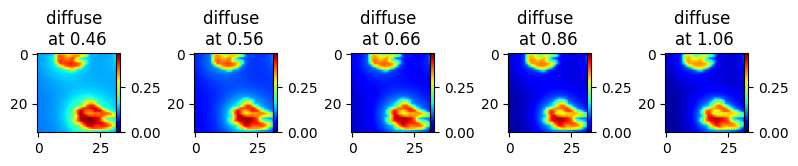

In [12]:
diffuse_fluxs = OrderedDict()

for wavelength in wavelengths:
    Z = np.zeros([rte_grid.x.size,rte_grid.y.size])
    for i, x in enumerate(rte_grid.x + 0.5*dx):
        for j, y in enumerate(rte_grid.y + 0.5*dy):
            
            sensor_images = sensor_dict.get_images('{}_Hemisphere_{}_{}'.format(wavelength,i,j))
            sensor_image = sensor_images[0]

            Image = sensor_image.I.T
            Image = Image.data.ravel()
            Image = Image.reshape([sensor_image.sizes['imgdim0'],sensor_image.sizes['imgdim1']],order='C')
            Image = Image.T

            # calculate global irradiance:
            int_exp2d = np.trapz(np.trapz(Image*np.cos(THETA)*np.sin(THETA), theta, axis=1), phi, axis=0)
            Z[i,j] = int_exp2d
            
    diffuse_fluxs[wavelength] = Z.T
fig,ax = plt.subplots(1,5, figsize=(8,3))
fontsize = 12

vmax = 0
for index, wavelength in enumerate(wavelengths):
    vmax = max(vmax, diffuse_fluxs[wavelength].max())
for index, wavelength in enumerate(wavelengths):
    im0 = ax[index].imshow(diffuse_fluxs[wavelength], cmap='jet', vmin=0, vmax=vmax )
#     im0 = ax[index].imshow((diffuse_fluxs[wavelength]+(direct_fluxs[wavelength]*np.abs(solarmu))), cmap='jet')#, vmin=0, vmax=vmax )

    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes("right", size="5%", pad=0)
    cb = plt.colorbar(im0, cax=cax)
    ax[index].set_title('diffuse \nat {}'.format(wavelength), fontsize=fontsize)

plt.tight_layout()       

Calculate PV transmissions based on

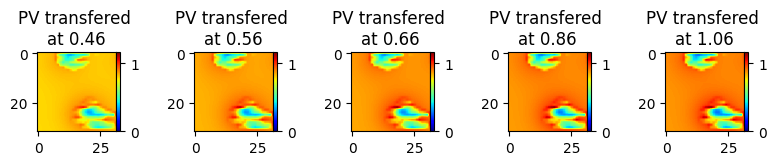

In [13]:
n = 1.5
theta_incident  = THETA # in radian
theta_refracted = np.arcsin((1/n)*np.sin(theta_incident))

a = np.sin(theta_incident - theta_refracted)**2
b = 2*np.sin(theta_incident + theta_refracted)**2

c = np.tan(theta_incident - theta_refracted)**2
d = 2*np.tan(theta_incident + theta_refracted)**2

Ri = (a/b) + (c/d)
Ri = np.nan_to_num(Ri).copy()

Ti = 1- Ri

# solar:
theta_incident  = np.deg2rad(180-SZA) # in radian
theta_refracted = np.arcsin((1/n)*np.sin(theta_incident))

a = np.sin(theta_incident - theta_refracted)**2
b = 2*np.sin(theta_incident + theta_refracted)**2

c = np.tan(theta_incident - theta_refracted)**2
d = 2*np.tan(theta_incident + theta_refracted)**2

Rd = (a/b) + (c/d)
Rd = np.nan_to_num(Rd).copy()

Td = 1- Rd
PV_transmmited = OrderedDict()

for wavelength in wavelengths:
    Z = np.zeros([rte_grid.x.size,rte_grid.y.size])
    for i, x in enumerate(rte_grid.x + 0.5*dx):
        for j, y in enumerate(rte_grid.y + 0.5*dy):
            
            sensor_images = sensor_dict.get_images('{}_Hemisphere_{}_{}'.format(wavelength,i,j))
            sensor_image = sensor_images[0]

            Image = sensor_image.I.T
            Image = Image.data.ravel()
            Image = Image.reshape([sensor_image.sizes['imgdim0'],sensor_image.sizes['imgdim1']],order='C')
            Image = Image.T
            
            # calculate transmmited irradiance:
            q1  = Ti*Image*np.cos(THETA)*np.sin(THETA)
            DNI = Td*(direct_fluxs[wavelength].T[i,j]*np.abs(solarmu))
            DHI = np.trapz(np.trapz(q1, theta, axis=1), phi, axis=0)
            GHI = DNI + DHI

            Z[i,j] = GHI
            
    PV_transmmited[wavelength] = Z.T
fig,ax = plt.subplots(1,5, figsize=(8,3))
fontsize = 12

vmax = 0
for index, wavelength in enumerate(wavelengths):
    vmax = max(vmax, PV_transmmited[wavelength].max())
for index, wavelength in enumerate(wavelengths):
    im0 = ax[index].imshow(PV_transmmited[wavelength], cmap='jet', vmin=0, vmax=vmax )

    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes("right", size="5%", pad=0)
    cb = plt.colorbar(im0, cax=cax)
    ax[index].set_title('PV transfered \nat {}'.format(wavelength), fontsize=fontsize)

plt.tight_layout()

In [14]:
# fig,ax = plt.subplots(1,5, figsize=(8,3))
# fontsize = 12

# vmax = 0
# for index, wavelength in enumerate(wavelengths):
#     e = (diffuse_fluxs[wavelength]+(direct_fluxs[wavelength]*np.abs(solarmu))) - PV_transmmited[wavelength]
#     vmax = max(vmax, e.max())
# for index, wavelength in enumerate(wavelengths):
#     e = (diffuse_fluxs[wavelength]+(direct_fluxs[wavelength]*np.abs(solarmu))) - PV_transmmited[wavelength]
#     im0 = ax[index].imshow(e, cmap='jet', vmin=0, vmax=vmax )

#     divider = make_axes_locatable(ax[index])
#     cax = divider.append_axes("right", size="5%", pad=0)
#     cb = plt.colorbar(im0, cax=cax)
#     ax[index].set_title('PV transfered \nat {}'.format(wavelength), fontsize=fontsize)

# plt.tight_layout()


#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------
#--------------------------------------------------------------

# F = np.zeros([rte_grid.x.size,rte_grid.y.size,len(wavelengths)])
    
# fig,ax = plt.subplots(1,2, figsize=(8,3))

# wavelength = 0.66
# direct = data['normalize_direct_flux'][wavelength]*data['solarmu']
# diffuse = data['normalize_Diffused'][wavelength]
# total = solar_spectrum_values[2]*(direct + diffuse)

# im0 = ax[0].imshow(total, cmap='jet' )
# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes("right", size="5%", pad=0)
# cb = plt.colorbar(im0, cax=cax)
# ax[0].set_title('total \nat {}'.format(wavelength), fontsize=fontsize)


# im0 = ax[1].imshow(solar_spectrum_values[2]*data['PV_transmmited'][wavelength], cmap='jet' )
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes("right", size="5%", pad=0)
# cb = plt.colorbar(im0, cax=cax)
# ax[1].set_title('PV trans. \nat {}'.format(wavelength), fontsize=fontsize)


#### Summarize the results

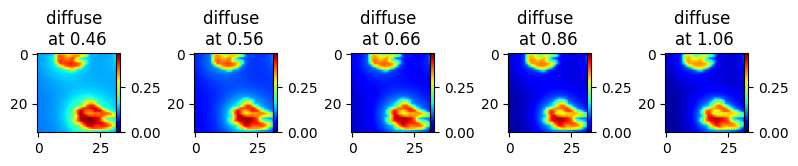

In [18]:
data = {'normalize_Diffused':diffuse_fluxs,'normalize_direct_flux':direct_fluxs,'solarmu':np.abs(solarmu),\
         'PV_transmmited':PV_transmmited}
fig,ax = plt.subplots(1,5, figsize=(8,3))
fontsize = 12

vmax = 0
for index, wavelength in enumerate(wavelengths):
    vmax = max(vmax, diffuse_fluxs[wavelength].max())
for index, wavelength in enumerate(wavelengths):
    im0 = ax[index].imshow(data['normalize_Diffused'][wavelength], cmap='jet', vmin=0, vmax=vmax )
#     im0 = ax[index].imshow((diffuse_fluxs[wavelength]+(direct_fluxs[wavelength]*np.abs(solarmu))), cmap='jet')#, vmin=0, vmax=vmax )

    divider = make_axes_locatable(ax[index])
    cax = divider.append_axes("right", size="5%", pad=0)
    cb = plt.colorbar(im0, cax=cax)
    ax[index].set_title('diffuse \nat {}'.format(wavelength), fontsize=fontsize)

plt.tight_layout()

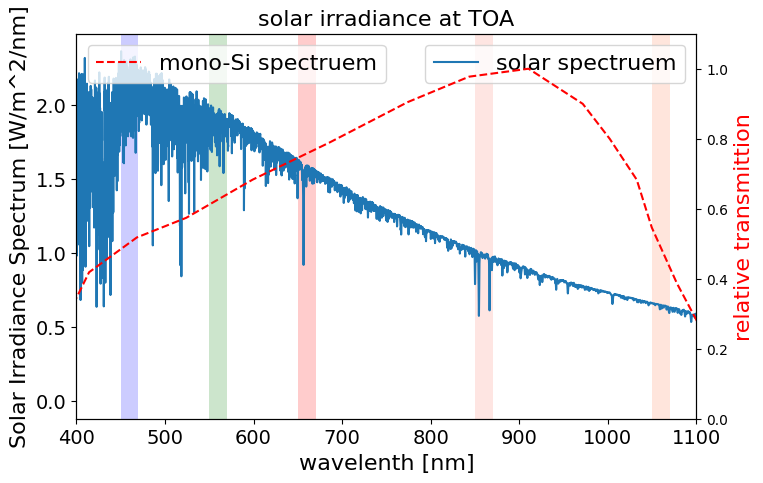

In [27]:
solar_spectrum_filename = "../AT3D/data/ancillary/SpectralSolar_MODWehrli_1985_WMO.npz"
dataset = np.load(solar_spectrum_filename)
solar_spectrum_wavelengths = dataset['Wavelengths']
Spectral_Irradiance = dataset['SolarSpectralIrradiance']
description = dataset['description']
source = dataset['source']
wavelength_units = dataset['wavelength_units']
Spectral_Irradiance_units = dataset['solarspectralirradiance_units']
    
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(solar_spectrum_wavelengths,Spectral_Irradiance ,label = 'solar spectruem')

ax.set_title('solar irradiance at TOA', fontsize=16)
ax.set_xlabel('wavelenth [nm]', fontsize=16)
ax.set_ylabel('Solar Irradiance Spectrum [W/m^2/nm]', fontsize=16)
ax.set_xlim([400,1100])
ax.tick_params(labelsize=14)

ax.legend(fontsize=16)

interpolater = interp1d(solar_spectrum_wavelengths, Spectral_Irradiance)
solar_spectrum_values = interpolater(1000*wavelengths)

facecolors = ['blue','green','red','salmon','coral']
for index, wavelength in enumerate(wavelengths):
    ax.axvspan(1e3*wavelength-10,\
                1e3*wavelength+10, facecolor=facecolors[index], alpha=0.2)
    
#load the PV spectrum:
PV_spectrum_filename = os.path.join(ref_folder,"mono-si_spectrum.csv")
E_PV_spectrum = pd.read_csv(PV_spectrum_filename,index_col=False,header=None)
PV_spectrum_wavelengths = E_PV_spectrum[0].values
E_PV_spectrum = E_PV_spectrum[1].values

E_PV_spectrum[E_PV_spectrum < 0] = 0  # if mistakly there are negative values.
interpolater = interp1d(PV_spectrum_wavelengths, E_PV_spectrum)

PV_spectrum = interpolater(1000*wavelengths)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(PV_spectrum_wavelengths, E_PV_spectrum/E_PV_spectrum.max(), 'r--',markersize=12,label = 'mono-Si spectruem')
ax2.set_ylim([0,1.1])
ax2.set_ylabel('relative transmittion',color="red",fontsize=16)

ax2.legend(fontsize=16)

#### Load all data and process

In [23]:
pkl_file_name_p_1std = os.path.join(ref_folder,  'PV_beta_p_1std.pkl') 
pkl_file_name_m_1std = os.path.join(ref_folder,  'PV_beta_m_1std.pkl') 
pkl_file_name_est = os.path.join(ref_folder,  'PV_beta_est.pkl') 

with open(pkl_file_name_p_1std, 'rb') as f:
    data_p_1std = pickle.load(f)
with open(pkl_file_name_m_1std, 'rb') as f:
    data_m_1std = pickle.load(f)
with open(pkl_file_name_est, 'rb') as f:
    data_est = pickle.load(f)

data_oreder = ['beta_est','beta_p_1std','beta_m_1std']
ALL_DATA = OrderedDict()
ALL_DATA['beta_est'] = data_est
ALL_DATA['beta_p_1std'] = data_p_1std
ALL_DATA['beta_m_1std'] = data_m_1std


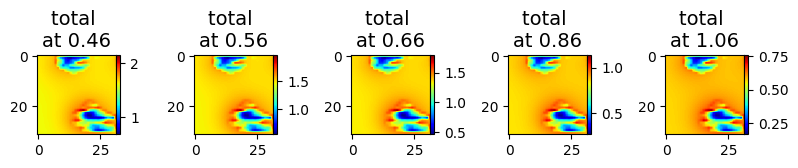

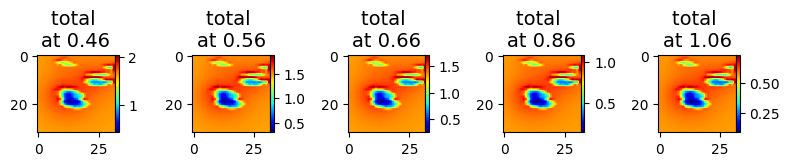

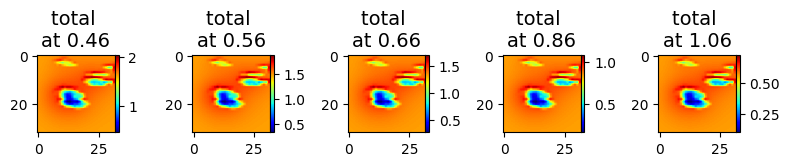

In [24]:
FINAL_ALL_DATA = OrderedDict()
fontsize = 14

for data_index, data_sample in ALL_DATA.items():
    
    F = np.zeros([rte_grid.x.size,rte_grid.y.size,len(wavelengths)])
    
    fig,ax = plt.subplots(1,5, figsize=(8,3))

    for wavelength_index, wavelength in enumerate(wavelengths):
        direct = data_sample['normalize_direct_flux'][wavelength]*data_sample['solarmu']
        diffuse = data_sample['normalize_Diffused'][wavelength]
        total = solar_spectrum_values[wavelength_index]*(direct + diffuse)
        
        PV_TRANSMITED = solar_spectrum_values[wavelength_index]*data_sample['PV_transmmited'][wavelength]
        
        im0 = ax[wavelength_index].imshow(PV_TRANSMITED, cmap='jet' )
        divider = make_axes_locatable(ax[wavelength_index])
        cax = divider.append_axes("right", size="5%", pad=0)
        cb = plt.colorbar(im0, cax=cax)
        ax[wavelength_index].set_title('total \nat {}'.format(wavelength), fontsize=fontsize)
        
#         F[...,wavelength_index] = total
        F[...,wavelength_index] = PV_TRANSMITED
        
    FINAL_ALL_DATA[data_index] = F

        
        
    plt.tight_layout()        

#### Show results

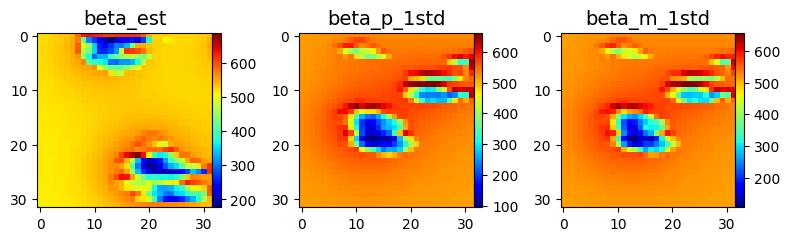

In [25]:
k = 0
F = OrderedDict()
fig,ax = plt.subplots(1,3, figsize=(8,3))

for data_index, data_sample in FINAL_ALL_DATA.items():
    
    total = np.zeros([rte_grid.x.size,rte_grid.y.size,len(wavelengths)])

    for wavelength_index, wavelength in enumerate(wavelengths):
        total[...,wavelength_index] = PV_spectrum[wavelength_index]*data_sample[...,wavelength_index]
        
    INT = np.trapz(total, 1000*wavelengths, axis=2)

    im0 = ax[k].imshow(INT, cmap='jet' )
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes("right", size="5%", pad=0)
    cb = plt.colorbar(im0, cax=cax)
    ax[k].set_title(data_index, fontsize=fontsize)
        
    F[data_index] = INT
    k += 1
        
        
plt.tight_layout()        

(0.0, 1.55, 0.0, 1.55)

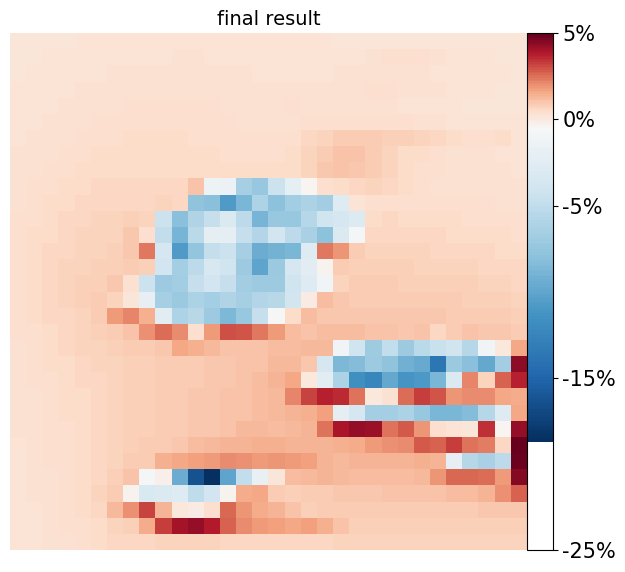

In [26]:
# https://stackoverflow.com/questions/59638155/how-to-set-0-to-white-at-a-uneven-color-ramp
result = (F['beta_p_1std'] - F['beta_m_1std'])/F['beta_est']

negatives = result.min()
positives = result.max()

bounds_min = np.linspace(negatives, 0, 100)
bounds_max = np.linspace(0, positives, 100)[1:]
    # the zero is only needed once
    # in total there will be 257 bounds, so 256 bins
bounds = np.concatenate((bounds_min, bounds_max), axis=None)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)


fig,ax = plt.subplots(1,1, figsize=(7,7))

extent = [rte_grid.x.min(),rte_grid.x.max(),
          rte_grid.y.min(), rte_grid.y.max()]


im0 = ax.imshow(100*result, origin = 'lower',  extent=extent,  cmap=cmap_2neg_4pos ,vmin=100*result.min(), vmax=100*0.05)
    

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
cb = plt.colorbar(im0, cax=cax)
ax.set_title('final result', fontsize=fontsize)

cb.ax.tick_params(labelsize=15)

cb.set_ticks([5, 0, -5, -15,-25])
cb.set_ticklabels(['5%', '0%', '-5%', '-15%', '-25%'])


ax.tick_params(labelsize=16)
ax.axis("off")